In [1]:
import xarray as xr
from tqdm import tqdm
from pyproj import Geod
import numpy as np

#Load the dataset using cfgrib engine
ds = xr.load_dataset("adaptor.mars_constrained.internal-1694633582.6876452-12569-11-e22c8590-d20d-4b9a-99da-0890618a8a48.grib", engine="cfgrib")

for v in ds:
    print(f"{v}, {ds[v].attrs['long_name']}, {ds[v].attrs['units']}")

co2fire, Wildfire flux of Carbon Dioxide, kg m**-2 s**-1
cofire, Wildfire flux of Carbon Monoxide, kg m**-2 s**-1
ch4fire, Wildfire flux of Methane, kg m**-2 s**-1
noxfire, Wildfire flux of Nitrogen Oxides NOx, kg m**-2 s**-1


# Compute the total kg emissions for the region of Canada

In [2]:
# Only keep the approximate region of Canada (latitude and longitude ranges)
min_lat = 83
max_lat = 42
min_lon = -141 + 360
max_lon = -53 + 360

can = ds.sel(longitude=slice(min_lon, max_lon), latitude=slice(min_lat, max_lat))
can = dict(
    ch4 = can.ch4fire,
    co = can.cofire,
    co2 = can.co2fire,
    nox = can.noxfire,
)

In [3]:
# Function to get area from latitude and longitude, assuming the given resolution of 0.1'

geod = Geod('+a=6378137 +f=0.0033528106647475126')

def get_area(latitude, longitude, resolution = 0.1):
    coordinates = np.array([
        [longitude, latitude], 
        [longitude, latitude - resolution], 
        [longitude+resolution, latitude - resolution], 
        [longitude+resolution, latitude]])
    lats = coordinates[:,1]
    lons = coordinates[:,0]
    area, perim = geod.polygon_area_perimeter(lons, lats)
    return area


In [6]:
import numpy as np
from pprint import pprint

# Compute sums of emissions over the days (in KG, from Kg.m-2.s-1)
sums = dict()

def get_kg_day(day, name):
    kgs = 0
    # Convert to dataframe to easily drop nan and compute kg/s for all region
    day_df = day.to_dataframe().dropna()
    for latlon in day_df.index:
        kgs += day_df[name][latlon] * get_area(latlon[0], latlon[1]-360) # kg/m2s to kg/s, multiply by affected area

    return kgs

for gas in can.keys():
    arr = can[gas].where(can[gas] != 0, drop=True)

    kgs_per_day =  [get_kg_day(day, f"{gas}fire") for day in tqdm(arr, desc=gas)]

    sums[gas] = np.sum(kgs_per_day) * 86400 # Convert from kg/s to kg
    
pprint(sums)

nox: 100%|██████████| 91/91 [00:01<00:00, 66.51it/s]

{'ch4': 3216527976.3261724,
 'co': 70890698977.98528,
 'co2': 1058388359881.4309,
 'nox': 2287438307.963638}


# Map Generation

<Figure size 640x480 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

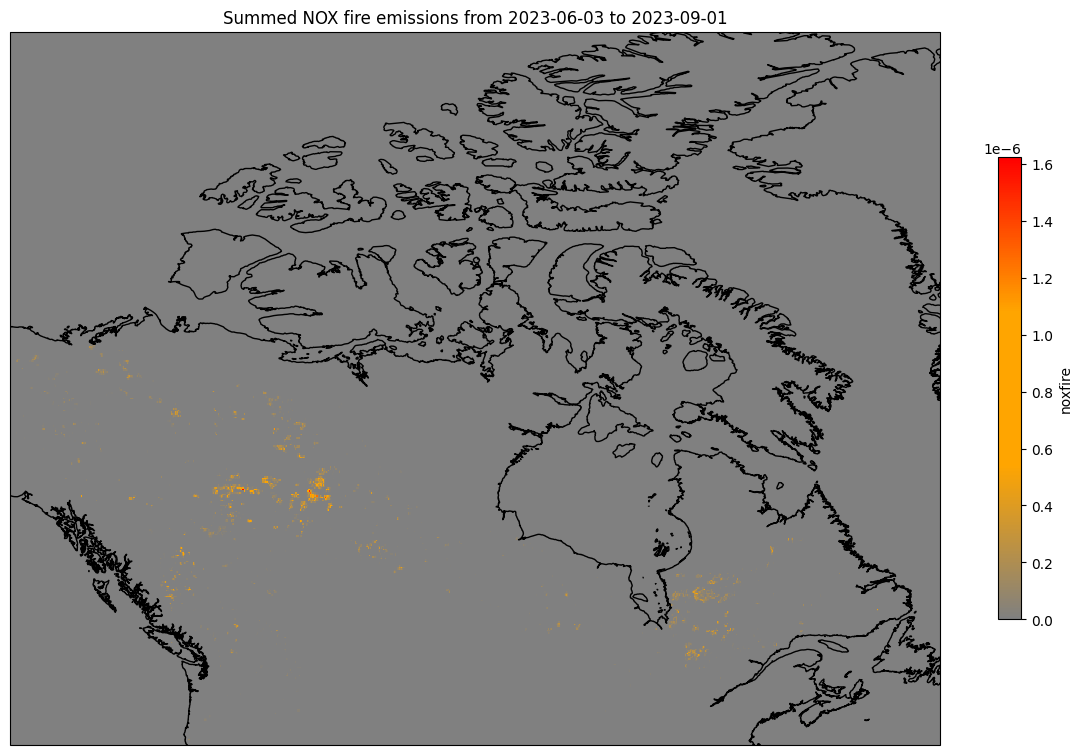

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy


# Generate sums:
for gas in can.keys():
    plt.clf()
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.Miller())
    ax.coastlines(resolution="10m")

    can[gas].sum("time").plot(cmap=LinearSegmentedColormap.from_list("", ["gray", "orange", "orange", "red"]),
                              transform=ccrs.PlateCarree(),
                              cbar_kwargs={"shrink": 0.6})
    plt.title(f"Summed {gas.upper()} fire emissions from 2023-06-03 to 2023-09-01")
    plt.savefig(f"{gas}.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from os import mkdir

Figure = plt.figure()
def AnimationFunction(frame, gas):
    plt.clf()
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.Miller())
    ax.coastlines(resolution="10m")

    can[gas][frame].plot(cmap=LinearSegmentedColormap.from_list("", ["gray", "orange", "orange", "red"]), transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6})
    plt.title(f"{gas.upper()} emission per second for {np.datetime_as_string(can[gas][frame]['time'].values, 'D')}")
    fig.savefig(f"{gas}/{str(frame).zfill(3)}.png")


# Create frames
for gas in can.keys():
    mkdir(gas)

    for i in tqdm(range(91)):
        AnimationFunction(i, gas)

In [22]:
import glob
from PIL import Image

def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(f"{frame_folder}.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=1000)

for gas in can.keys():
    make_gif(gas)